# MNISTの訓練プログラム (Keras)

## 基本な処理

In [1]:
# TensorFlowのバージョンを下げる
# インストール
#!pip install tensorflow==1.14
#!pip install tensorflow-gpu==1.14 # GPU を利用するための TensorFlow インストール
#!pip install keras==2.2.4
RESEARCH_WORK_PATH = "/content/drive/My Drive/Colab Notebooks/BachelorResearch/"

In [2]:
# モジュールのインポート
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

## データの読み込み

In [3]:
import os
from PIL import Image

def path_to_pic(dir_folder):
    list_of_pic = []
    for file in os.listdir(dir_folder):
        if file.endswith(".jpg"):
            directory = "%s%s" % (dir_folder, file)
            list_of_pic.append(directory)
    return list_of_pic

def make_dataset(path):
  x = []
  y = []
  clss = [1, 2, 3, 4]
  for cls in clss:
    for pic in path_to_pic(path + '/' + 'Q' + str(cls) + '/'):
      im = np.array(Image.open(pic))
      x.append(im)
      y.append(cls-1)
  x = np.array(x)
  y = np.array(y)
  return x,y

In [4]:
datapath = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/MER_audio_taffc_dataset_wav/2s/stft_crop_0.2"
# datapath = "C:/Users/A/Desktop/stft_crop_0.2"

# MNISTデータ読み出し
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

x,y = make_dataset(datapath)
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x)
y_train, y_test = train_test_split(y)

# データの確認
print('Data Shape:')
print('x_train = {}, y_train = {}'.format(x_train.shape, y_train.shape)) 
print('x_test = {}, y_test = {}'.format(x_test.shape, y_test.shape)) 
print('')

# データの表示
# for i in range(81):
  # plt.imshow(x_train[i], cmap='gray')
  # plt.show()

Data Shape:
x_train = (8400, 102, 173), y_train = (8400,)
x_test = (2800, 102, 173), y_test = (2800,)



In [5]:
# CNN 用にデータを形状を変更(CNNの場合：データ数x28x28x1に変更する)
cnn_x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
cnn_x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

# 分類するカテゴリの数
num_classes = 4

# CNNn 用の入力の形状
cnn_input_shape = cnn_x_train.shape[1:]
print(cnn_input_shape)

# CNN 用のデータの前処理
cnn_x_train = cnn_x_train.astype('float32')
cnn_x_test = cnn_x_test.astype('float32')
cnn_x_train /= 255
cnn_x_test /= 255

# 出力をone hot vector形式に変換
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# CNN 用のデータセットの用意
cnn_dataset = (cnn_x_train, y_train, cnn_x_test, y_test)

(102, 173, 1)


## モデルの定義

## 畳み込み層とプーリング層を増やした CNN

In [6]:
def cnn(input_shape, num_classes):# https://github.com/MuAuan/SSD/blob/master/VGG_family/cifar10_VGG_family.py
    input_layer = Input(shape=input_shape)

    # Block 1
    conv1_1 = Conv2D(64, (3, 3),name='conv1_1', activation='relu', padding='same')(input_layer)
    conv1_2 = Conv2D(64, (3, 3),name='conv1_2', activation='relu', padding='same')(conv1_1)
    bn1 = BatchNormalization(axis=3)(conv1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    drop1 = Dropout(0.5)(pool1)

    # Block 2
    conv2_1 = Conv2D(128, (3, 3),name='conv2_1', activation='relu', padding='same')(drop1)
    conv2_2 = Conv2D(128, (3, 3),name='conv2_2', activation='relu', padding='same')(conv2_1)
    bn2 = BatchNormalization(axis=3)(conv2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    drop2 = Dropout(0.5)(pool2)

    # Block 3
    conv3_1 = Conv2D(256, (3, 3),name='conv3_1', activation='relu', padding='same')(drop2)
    conv3_2 = Conv2D(256, (3, 3),name='conv3_2', activation='relu', padding='same')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3),name='conv3_3', activation='relu', padding='same')(conv3_2)
    conv3_4 = Conv2D(256, (3, 3),name='conv3_4', activation='relu', padding='same')(conv3_3)
    bn3 = BatchNormalization(axis=3)(conv3_4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    drop3 = Dropout(0.5)(pool3)

    # Block 4
    conv4_1 = Conv2D(512, (3, 3),name='conv4_1', activation='relu', padding='same')(drop3)
    conv4_2 = Conv2D(512, (3, 3),name='conv4_2', activation='relu', padding='same')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3),name='conv4_3', activation='relu', padding='same')(conv4_2)
    conv4_4 = Conv2D(512, (3, 3),name='conv4_4', activation='relu', padding='same')(conv4_3)
    bn4 = BatchNormalization(axis=3)(conv4_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)
    drop4 = Dropout(0.5)(pool4)

    # Block 5
    conv5_1 = Conv2D(512, (3, 3),name='conv5_1', activation='relu', padding='same')(drop4)
    conv5_2 = Conv2D(512, (3, 3),name='conv5_2', activation='relu', padding='same')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3),name='conv5_3', activation='relu', padding='same')(conv5_2)
    conv5_4 = Conv2D(512, (3, 3),name='conv5_4', activation='relu', padding='same')(conv5_3)
    bn5 = BatchNormalization(axis=3)(conv5_4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(bn5)
    drop5 = Dropout(0.5)(pool5)
    
    x = Flatten()(drop5)
    x = Dense(4096)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

## 学習関数の定義

In [7]:
# 学習状況のプロット関数の定義
def plot_history(history):
    # 分類精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

    # 損失関数の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

In [8]:
  # 学習用の関数の定義
def train(model, algorithm, dataset, batch = 64, epochs = 50, v = 1):
    
    x_train, y_train, x_test, y_test = dataset
    
    # モデルのサマリ表示
    model.summary()
    
    # モデルのコンパイル
    model.compile(loss = 'categorical_crossentropy',
              optimizer = algorithm,
              metrics = ['accuracy'])
    
    # 学習
    history = model.fit(x_train, y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=v,
          validation_data=(x_test, y_test))
    
    # プロット
    plot_history(history)
    
    # 学習後の評価
    score_train = model.evaluate(x_train, y_train, verbose=0)    
    score_test = model.evaluate(x_test, y_test, verbose=0)    

    print('Test accuracy:', score_test[1])
    print('Test loss:', score_test[0])

## モデルを読み込み学習

## 畳み込みとプーリングを増やした CNN の認識実験

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 173, 1)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 102, 173, 64)      640       
                                                                 
 conv1_2 (Conv2D)            (None, 102, 173, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 102, 173, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 51, 86, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 51, 86, 64)        0     

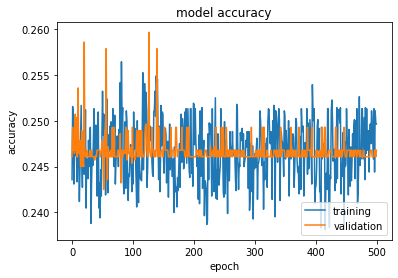

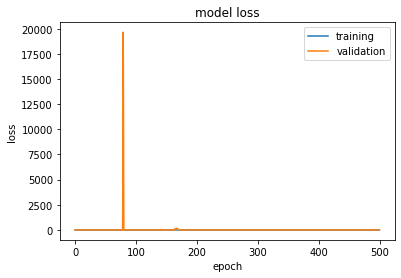

Test accuracy: 0.2467857152223587
Test loss: 1.386447548866272


In [9]:
# モデルの読み込み
cnn_model = cnn(cnn_input_shape, num_classes)
# 最適化アルゴリズムを選択
algorithm = 'adam'
# 学習開始
train(cnn_model, algorithm, cnn_dataset, epochs = 500)

In [10]:
cnn_model.save(RESEARCH_WORK_PATH + "models/VGG16_crop0.2")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/BachelorResearch/models/VGG16_crop0.2/assets
